In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Model
<figure><img src="../../../images/modelo_musculo2.png\" width=400 />


## Deduction

   $ F_{SEE} = \left\{\begin{array}{l}
   0\ \ , \ \ L_T < L_{SL}\\
   K(L - L_{SL})^2 \ \ , \ \ L_T \geq L_{SL}\\
   \end{array}
   \right.$
   
   $F_{KPE} = \left\{\begin{array}{l}
   0\ \ , \ \ L_{CE} < L_{op}\\
   K(L - L_{op})^2 \ \ , \ \ L_{CE} \geq L_{op}\\
   \end{array}
   \right.$
     
  
   $F = F_{SEE} - F_{KPE} = F_{CE} $
     
   $\dot L_{CE} = (0.25 + 0.75a)V_{max}\frac{F_{CE}-aF_L}{b} $
   
   $ b = \left\{\begin{array}{l}
   aF_L + F_{CE}/A_f\ \ , \ \ F_{CE} < F_L\\
   \frac{(2 + 2/A_f)(aF_L\overline{F}^M_{len} - F_{CE})}{\overline{F}^M_{len} - 1}   \ \ , \ \ F_{CE} \geq F_L\\
   \end{array}
   \right.$
   
   $\frac{da}{dt} = \frac{u - a}{\tau_a(u,a)}$
   
   $\tau_a(a,u) = \left\{\begin{array}{l}
   \tau_{act}(0.5 + 1.5a)\ \ , \ \ u > a\\
   \frac{\tau_{dact}}{(0.5 + 1.5a)}\ \ , \ \ u \leq a\\
   \end{array}
   \right.$
   
   $L_{SEE} = L_m - L_{CE}$

## Parameters

In [2]:
## Propriedades

L_SL = 0.223
#Umax = 0.04
#width = 0.63
#a = 0.25
#b = 0.25*10

## Condições Iniciais
L_CEOPT = 0.093
L_CE_norm = 0.087/L_CEOPT
Fmax = 3000

L_SL_norm = L_SL/L_CEOPT
dt = 0.001
t = np.arange(0,3,dt)
a =  np.empty_like(t)
F_tendon_norm = np.empty_like(t)
F_kpe_norm = np.empty_like(t)
F_CE_norm = np.empty_like(t)
F_tot = np.empty_like(t)
fiber_length = np.empty_like(t)
tendon_length = np.empty_like(t)

## Functions

In [3]:
def computeTendonForce (L_SEE_norm,L_SL_norm):
    """
    ComputeTendonForce
    
    Inputs:
    
        L_SEE_norm - Normalized tendon length
    
        L_SL_norm - Normalized slack length of the tendon
    
        L_CEOPT = Optimal length of the fiber
        
    Output:
        F_tendon_norm - Normalized tendon force
    
    """
    Umax = 0.04
    
    if L_SEE_norm < L_SL_norm:
        F_tendon_norm[i] = 0
    else:
        F_tendon_norm =  ((L_SEE_norm - L_SL_norm)/(Umax*L_SL_norm))**2
        
    return F_tendon_norm

In [4]:
def computeParalelElementForce (L_CE_norm,L_SL_norm):
    """
    Compute Paralel Elemento Force
    
    Inputs:
    
        L_CE_norm - Normalized Contract Element length
    
        L_SL_norm - Normalized slack length of the tendom
    
        L_CEOPT = Optimal length of the fiber
        
    Output:
        F_kpe_norm - Normalized paralel element force
    
    """
    
    Umax = 0.04
    
    if L_CE_norm < 1:
        F_kpe_norm = 0
    else:
        F_kpe_norm = ((L_CE_norm - 1)/(Umax*L_SL_norm))**2
        
    return F_kpe_norm

In [5]:
def computeForceLengthCurve (L_CE_norm):
    """
    Compute Force Length Curve
    
    Inputs:
    
        L_CE_norm - Normalized Contract Element length
        
    Output:
        F_Lnorm - Normalized Force Length Element
    
    """
    width = 0.63
    
    F_Lnorm = max(0,(1-((L_CE_norm-1)/width)**2))
        
    return F_Lnorm

In [6]:
def computeForceContract (F_tendon_norm,F_kpe_norm ):
    """"
    Incremental Contract Element's length
    
    Inputs:
    
        F_tendon_norm - Normalized tendon force
        
        F_CE_norm - Normalized Contract Element Force
        
    Output:
        F_kpe_norm - Normalized paralel element force
      
    """
    
    F_CE_norm = F_tendon_norm - F_kpe_norm
        
    return F_CE_norm

In [7]:
def computeActivation (a,u,dt):
    """
    Compute Activation parameter
    
    Inputs:
    
        a - Muscle activation parameter
        
        u - Muscle excitation signal
        
        dt - time step
        
    Output:
        a - Muscle activation parameter
    
    """
    tal_dact = 0.050 #young #ms
    #tal_dact = 0.060 #old #ms
    tal_act = 0.015 #ms
    
    if u > a:
        tal_a = tal_act*(0.5 + 1.5*a)
    else:
        tal_a = tal_dact/(0.5 + 1.5*a)
    
    
    a = a + dt*(u-a)/tal_a    
    
    return a

In [8]:
def dLCEdt (F_Lnorm, F_CE_norm,a):
    """"
    Incremental Contract Element's length
    
    Inputs:
    
        F_Lnorm - Normalized Force Length Element
        
        F_kpe_norm - Normalized paralel element force
        
    Output:
        L_CE_dot - Incremental Contract Element's length
             
    """
    A = 0.25
    F_m_len = 1.4 #young
    #F_m_len = 1.8 #old
    v_max = 10 #young
    #v_max = 8 #old
    
    if F_CE_norm <= a*F_Lnorm:
        b = a*F_Lnorm + F_CE_norm/A
        
    else:
        b = (2 + 2/A)*(a*F_Lnorm*F_m_len - F_CE_norm)/(F_m_len - 1)
        
    L_CE_dot = (0.25 + 0.75*a)*v_max*(F_CE_norm - a*F_Lnorm)/b

    return L_CE_dot

## Muscle Model

In [9]:
for i in range(1,len(t)):
    #inputs
    if t[i] <= 1:
        L_m = 0.31
    elif (t[i]>1 and t[i] < 2):
        L_m = 0.31 - 0.04 * (t[i] - 1)
    
    u = 1
        
    #################################################################################################################
        
    L_SEE_norm = L_m/L_CEOPT - L_CE_norm
    
    F_tendon_norm[i] = computeTendonForce(L_SEE_norm,L_SL_norm)
        
    F_kpe_norm[i] = computeParalelElementForce(L_CE_norm,L_SL_norm)
        
    F_Lnorm = computeForceLengthCurve(L_CE_norm)
    
    F_CE_norm[i] = computeForceContract(F_tendon_norm[i],F_kpe_norm[i])
    
    a[i] = computeActivation(a[i-1],u,dt)
        
    L_CE_norm = L_CE_norm + dt*dLCEdt (F_Lnorm,F_CE_norm[i],a[i])
    
    #################################################################################################################
    F_tot[i] = F_tendon_norm[i]*Fmax
    fiber_length[i] = L_CE_norm*L_CEOPT
    tendon_length[i] = L_SEE_norm*L_CEOPT
    

    

## Normalizade Tendon Force

Text(0,0.5,'Force [N]')

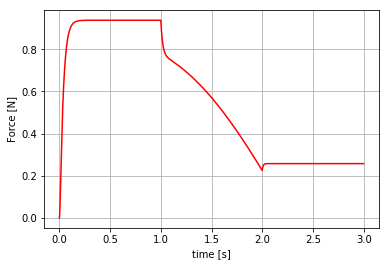

In [10]:
plt.plot(t,F_tendon_norm, c = 'red')
plt.grid()
plt.xlabel ('time [s]')
plt.ylabel ('Force [N]')

## Tendon Force

Text(0,0.5,'Force [N]')

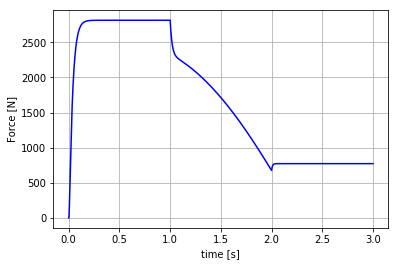

In [11]:
plt.plot(t,F_tot, c = 'blue')
plt.grid()
plt.xlabel ('time [s]')
plt.ylabel ('Force [N]')

## Length

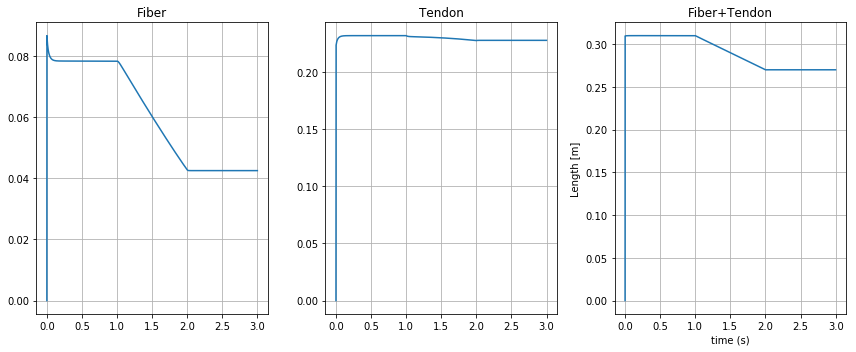

In [15]:
fig,  ax  =  plt.subplots(1, 3, figsize=(12, 5), sharex=True)

ax[0].plot(t, fiber_length, label = 'Fiber')
ax[0].set_title('Fiber')
ax[0].grid()
ax[1].plot(t, tendon_length, label = 'Tendon')
ax[1].set_title('Tendon')
ax[1].grid()
ax[2].plot(t, fiber_length+tendon_length, label = 'Fiber+Tendon')
ax[2].set_title('Fiber+Tendon')
ax[2].grid()
plt.xlabel('time (s)')
plt.ylabel('Length [m]')
plt.tight_layout()


## Activation

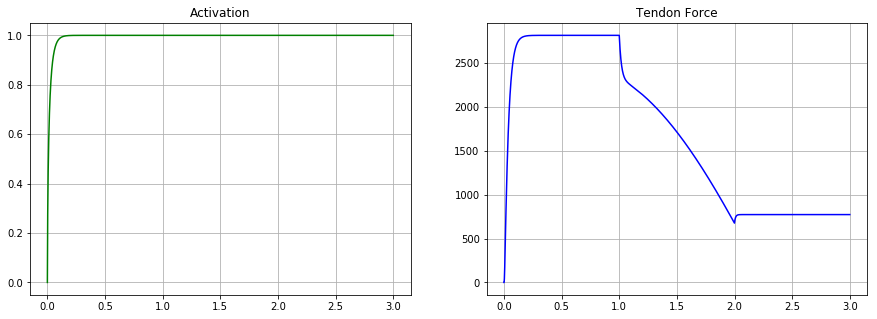

In [13]:
fig,  ax  =  plt.subplots(1, 2, figsize=(15, 5), sharex=True)

ax[0].plot(t, a, c = 'green')
ax[0].set_title('Activation')
ax[0].grid()
ax[1].plot(t, F_tot, c = 'blue')
ax[1].set_title('Tendon Force')
ax[1].grid()

## Tendon Force with Activation always 1

<figure><img src="../../../images/activation equals 1.png\" width=600 />